<a href="https://colab.research.google.com/github/jiajenemilylee/demand-planning/blob/main/sku-demand-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SKU Demand Forecasting Project**
\
📘 Full explanation and business insights available on Medium:  
🔗 [Read the full analysis here](https://medium.com/your-link)



---



# Step 1: Mount Google Drive and load the CSV

In [21]:
from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy kaggle.json
kaggle_path = '/content/drive/My Drive/DataProject/kaggle.json'
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
shutil.copy(kaggle_path, '/content/kaggle.json')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/kaggle.json'

In [22]:
import pandas as pd

# Locate the data set
file_path = '/content/drive/MyDrive/DataProject/supplyplanning/productdemandforecasting.csv'

df = pd.read_csv(file_path)
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Step 2: Get a basic understanding of the data

In [23]:
# Basic info and missing values
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


,0
Product_Code,0
Warehouse,0
Product_Category,0
Date,11239
Order_Demand,0


In [24]:
# Display the first few rows of the cleaned dataset
df.head()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Step 3: Clean and transform the data

In [25]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')

# Convert 'Order_Demand' to numeric: replace parentheses with negative signs and cast to numeric
df['Order_Demand'] = df['Order_Demand'].astype(str).str.replace('(', '-').str.replace(')', '')
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')

# Remove records with negative demand values (outliers)
df = df[df['Order_Demand'] >= 0]

# Create a 'YearMonth' column for monthly grouping
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)

# Display the first few rows of the cleaned dataset again
df.head()


,Product_Code,Warehouse,Product_Category,Date,Order_Demand,YearMonth
0,Product_0993,Whse_J,Category_028,2012-07-27,100,2012-07
1,Product_0979,Whse_J,Category_028,2012-01-19,500,2012-01
2,Product_0979,Whse_J,Category_028,2012-02-03,500,2012-02
3,Product_0979,Whse_J,Category_028,2012-02-09,500,2012-02
4,Product_0979,Whse_J,Category_028,2012-03-02,500,2012-03


In [26]:
df.info()
df.isnull().sum()  # Check if there are any missing values
df['Order_Demand'].describe()      # Review the distribution of Order_Demand (min, max, mean)


<class 'pandas.core.frame.DataFrame'>
Index: 1038106 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1038106 non-null  object        
 1   Warehouse         1038106 non-null  object        
 2   Product_Category  1038106 non-null  object        
 3   Date              1031437 non-null  datetime64[ns]
 4   Order_Demand      1038106 non-null  int64         
 5   YearMonth         1038106 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 55.4+ MB


,Order_Demand
count,1.038106e+06
mean,4.936488e+03
std,2.902462e+04
min,0.000000e+00
25%,2.000000e+01
50%,3.000000e+02
75%,2.000000e+03
max,4.000000e+06


# Step 4: Aggregate demand by "SKU + warehouse + month"

In [27]:
# # Aggregate total order demand by SKU, Warehouse, and Month
grouped_df = df.groupby(['Product_Code', 'Warehouse', 'YearMonth'])['Order_Demand'].sum().reset_index()

# Convert the result into a pivot table: rows = months, columns = SKU + warehouse, values = demand volume
pivot_df = grouped_df.pivot_table(
    index='YearMonth',
    columns=['Product_Code', 'Warehouse'],
    values='Order_Demand',
    fill_value=0  # Fill missing demand with 0
)

pivot_df.head()


Product_Code Product_0001        Product_0002        Product_0003         \
Warehouse          Whse_A Whse_J       Whse_C Whse_S       Whse_J Whse_S   
YearMonth                                                                  
2011-01               0.0    0.0          0.0    0.0          0.0    0.0   
2011-05               0.0    0.0          0.0    0.0          0.0    0.0   
2011-06               0.0    0.0          0.0    0.0          0.0    0.0   
2011-09               0.0    0.0          0.0    0.0          0.0    0.0   
2011-10               0.0    0.0          0.0    0.0          0.0    0.0   

Product_Code Product_0004 Product_0005 Product_0006 Product_0007  ...  \
Warehouse          Whse_J       Whse_J       Whse_J       Whse_J  ...   
YearMonth                                                         ...   
2011-01               0.0          0.0          0.0          0.0  ...   
2011-05               0.0          0.0          0.0          0.0  ...   
2011-06               0.0          0.0          0.0          0.0  ...   
2011-09               0.0          0.0          0.0          0.0  ...   
2011-10               0.0          0.0          0.0          0.0  ...   

Product_Code Product_2168               Product_2169                       \
Warehouse          Whse_A Whse_J Whse_S       Whse_A Whse_C Whse_J Whse_S   
YearMonth                                                                   
2011-01               0.0    0.0    0.0          0.0    0.0    0.0    0.0   
2011-05               0.0    0.0    0.0          0.0    0.0    0.0    0.0   
2011-06               0.0    0.0    0.0          0.0    0.0    0.0    0.0   
2011-09               0.0    0.0    0.0          0.0    0.0    0.0    0.0   
2011-10               0.0    0.0    0.0          0.0    0.0    0.0    0.0   

Product_Code Product_2170 Product_2171 Product_2172  
Warehouse          Whse_C       Whse_J       Whse_J  
YearMonth                                            
2011-01               0.0          0.0          0.0  
2011-05               0.0          0.0          0.0  
2011-06               0.0          0.0          0.0  
2011-09               0.0          0.0          0.0  
2011-10               0.0          0.0          0.0  

[5 rows x 2849 columns]

# Step 5: Select the focus SKU and warehouse

Using the top-performing SKUs for example

In [28]:
# Sort by total product demand quantity
top_sku = df.groupby(['Product_Code'])['Order_Demand'].sum().sort_values(ascending=False).head(5)
print(top_sku)


Product_Code
Product_1359    471592000
Product_1248    289022000
Product_0083    210539000
Product_1341    169777000
Product_1295    122647500
Name: Order_Demand, dtype: int64


In this project, I selected the top 3 SKUs

In [29]:
sku = 'Product_1359'
sku_warehouses = df[df['Product_Code'] == sku].groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False)
print(sku_warehouses)

sku = 'Product_1248'
sku_warehouses = df[df['Product_Code'] == sku].groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False)
print(sku_warehouses)

sku = 'Product_0083'
sku_warehouses = df[df['Product_Code'] == sku].groupby('Warehouse')['Order_Demand'].sum().sort_values(ascending=False)
print(sku_warehouses)

Warehouse
Whse_J    471592000
Name: Order_Demand, dtype: int64
Warehouse
Whse_J    289022000
Name: Order_Demand, dtype: int64
Warehouse
Whse_S    184498000
Whse_C     13257000
Whse_J     12784000
Name: Order_Demand, dtype: int64


# Step 6: Plotting the Trend Line

I selected top 3 SKUs from last step and plotted the monthly demand trend from 2011 to 2017 for each SKU and warehouse combination.

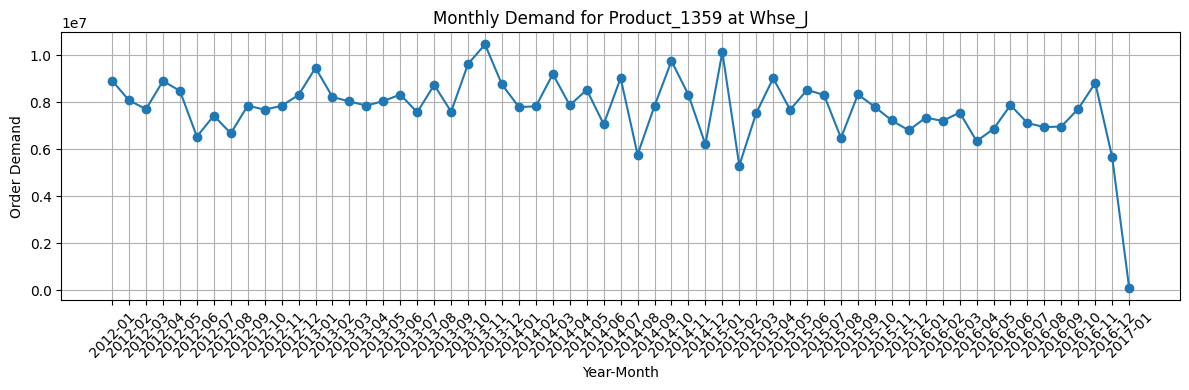

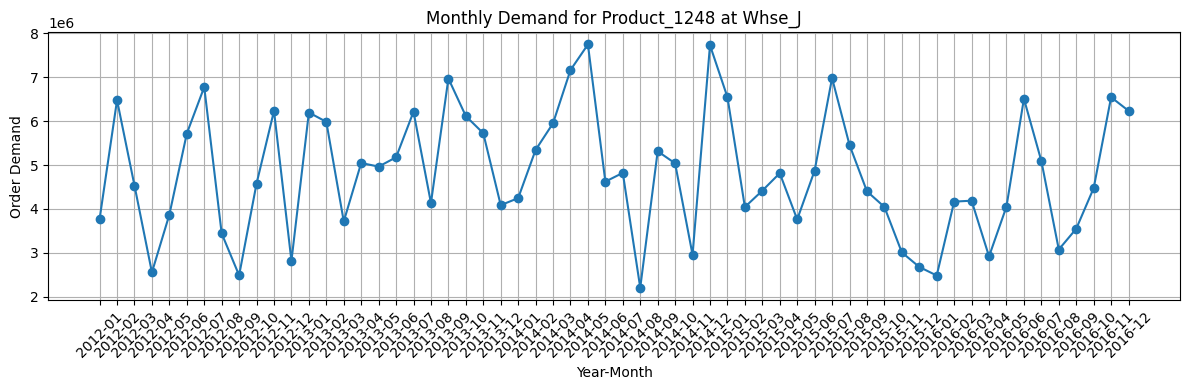

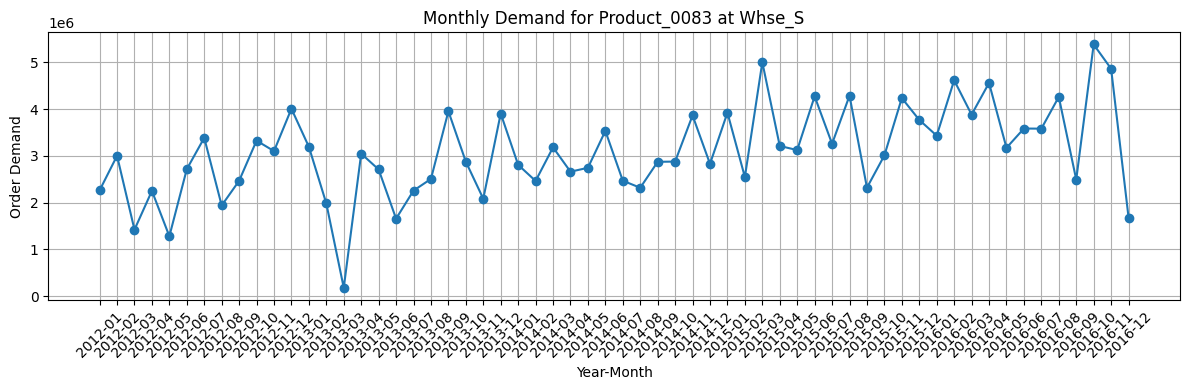

In [30]:
import matplotlib.pyplot as plt

# Define plotting function
def plot_sku_trend(sku, warehouse):
    data = grouped_df[(grouped_df['Product_Code'] == sku) &
                      (grouped_df['Warehouse'] == warehouse)]

    plt.figure(figsize=(12, 4))
    plt.plot(data['YearMonth'], data['Order_Demand'], marker='o')
    plt.title(f'Monthly Demand for {sku} at {warehouse}')
    plt.xlabel('Year-Month')
    plt.ylabel('Order Demand')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot three sets of data
plot_sku_trend('Product_1359', 'Whse_J')
plot_sku_trend('Product_1248', 'Whse_J')
plot_sku_trend('Product_0083', 'Whse_S')


To clearly review order demand, I combined three SKUs into a single chart, with each line shown in a different color.

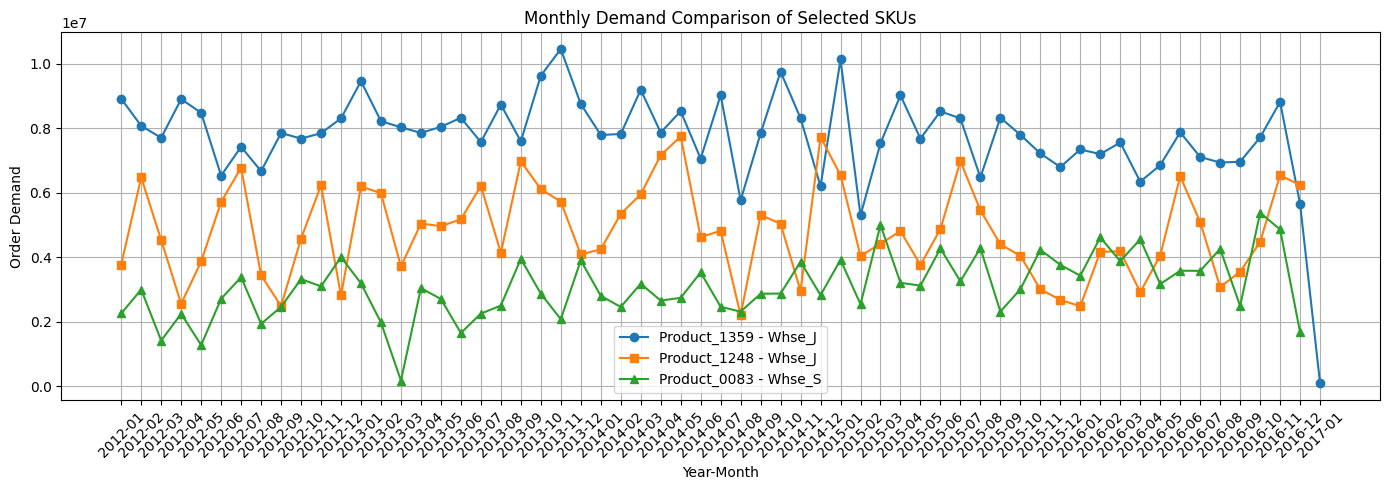

In [31]:
# Plot all three SKU demand trends in one chart
plt.figure(figsize=(14, 5))

# Product 1359 @ Whse_J
data1 = grouped_df[(grouped_df['Product_Code'] == 'Product_1359') &
                   (grouped_df['Warehouse'] == 'Whse_J')]
plt.plot(data1['YearMonth'], data1['Order_Demand'], marker='o', label='Product_1359 - Whse_J')

# Product 1248 @ Whse_J
data2 = grouped_df[(grouped_df['Product_Code'] == 'Product_1248') &
                   (grouped_df['Warehouse'] == 'Whse_J')]
plt.plot(data2['YearMonth'], data2['Order_Demand'], marker='s', label='Product_1248 - Whse_J')

# Product 0083 @ Whse_S
data3 = grouped_df[(grouped_df['Product_Code'] == 'Product_0083') &
                   (grouped_df['Warehouse'] == 'Whse_S')]
plt.plot(data3['YearMonth'], data3['Order_Demand'], marker='^', label='Product_0083 - Whse_S')

# Formatting
plt.title('Monthly Demand Comparison of Selected SKUs')
plt.xlabel('Year-Month')
plt.ylabel('Order Demand')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Step 7: Perform Seasonal Decomposition

This is to better understand the underlying trend, seasonality, and residuals for the three selected product SKUs.

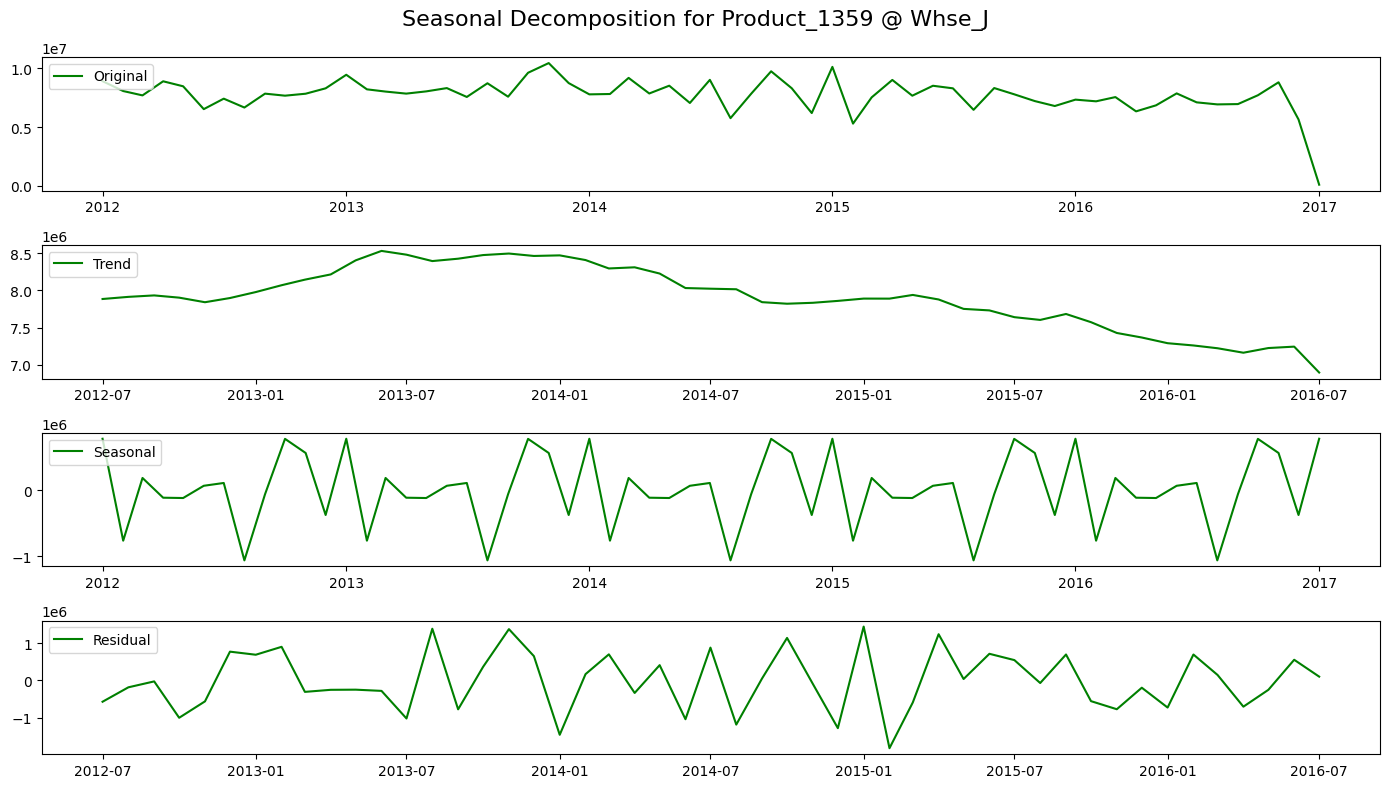

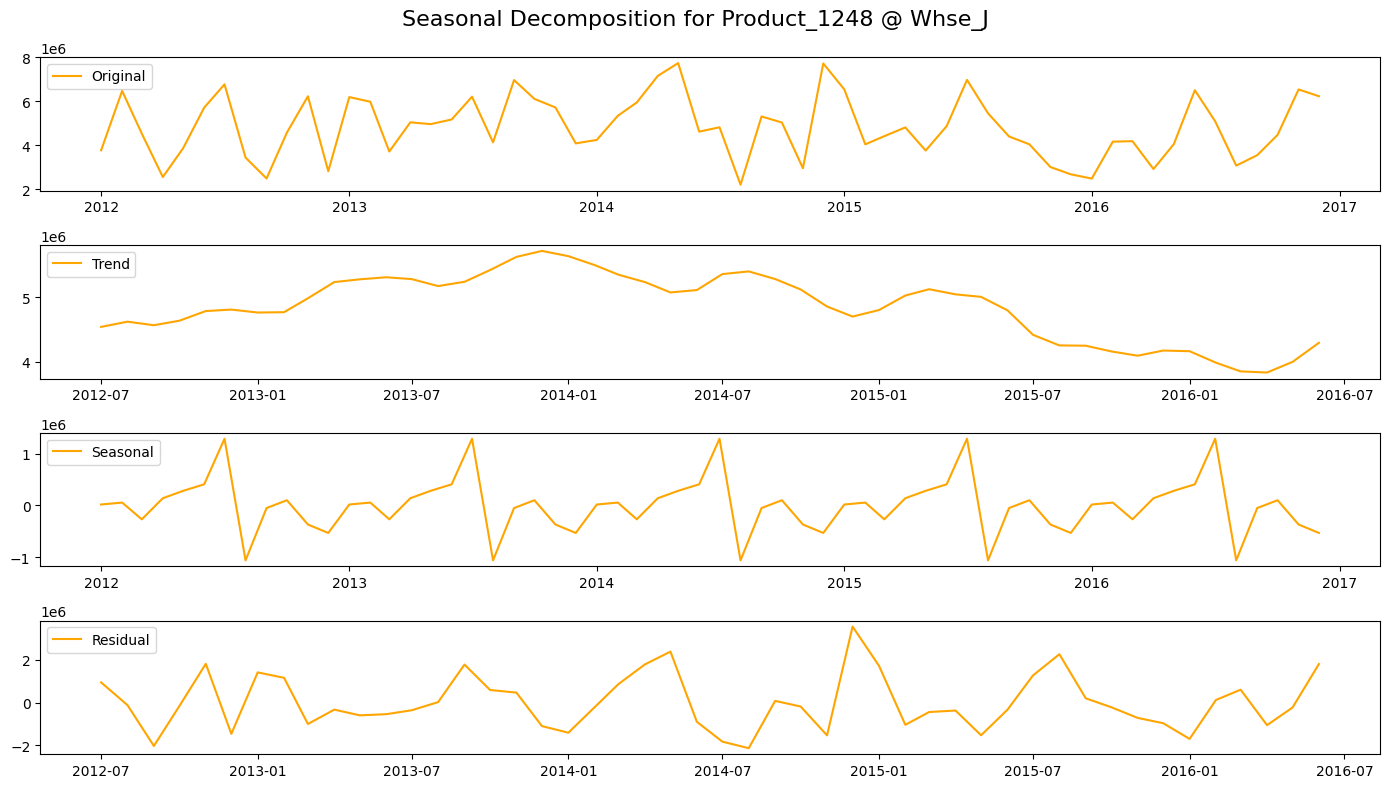

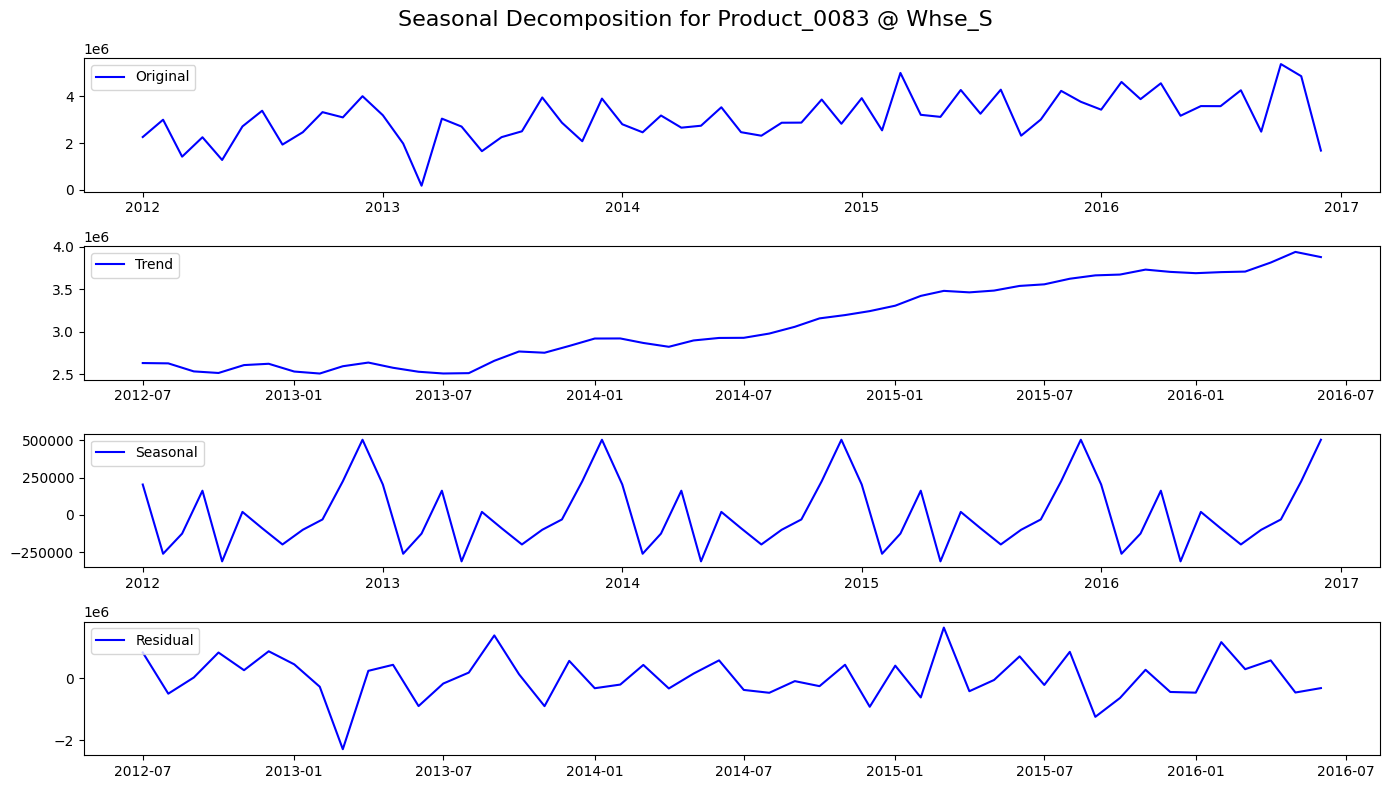

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

# Definition: Decompose and plot the time series for a specific SKU and warehouse using data from grouped_df
def decompose_and_plot(sku, warehouse, color):
    data = grouped_df[(grouped_df['Product_Code'] == sku) &
                      (grouped_df['Warehouse'] == warehouse)].copy()

    # Convert to datetime index and sort by time
    ts = data.set_index(pd.to_datetime(data['YearMonth'])).sort_index()
    ts = ts['Order_Demand']

    # Perform seasonal decomposition (period = 12 months)
    decomposition = seasonal_decompose(ts, model='additive', period=12)

    # Plot the decomposition results
    plt.figure(figsize=(14, 8))
    plt.suptitle(f"Seasonal Decomposition for {sku} @ {warehouse}", fontsize=16)

    plt.subplot(411)
    plt.plot(ts, label='Original', color=color)
    plt.legend(loc='upper left')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color=color)
    plt.legend(loc='upper left')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color=color)
    plt.legend(loc='upper left')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual', color=color)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Run decomposition for three sets of data
decompose_and_plot('Product_1359', 'Whse_J', 'green')
decompose_and_plot('Product_1248', 'Whse_J', 'orange')
decompose_and_plot('Product_0083', 'Whse_S', 'blue')


# Section 8 : Baseline Forecasts (Jan–Mar 2017)


In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd

# 預測函式：輸入 grouped_df 與要預測的 SKU + 倉庫
def forecast_baseline(df, product_code, warehouse, periods=3):
    data = df[(df['Product_Code'] == product_code) & (df['Warehouse'] == warehouse)].copy()
    ts = data.set_index(pd.to_datetime(data['YearMonth'])).sort_index()
    ts = ts['Order_Demand']
    ts = ts.asfreq('MS')  # 設定為每月起始，避免季節性分解錯誤

    # 季節性分解
    decomposition = seasonal_decompose(ts, model='additive', period=12, extrapolate_trend='freq')

    # 抓出最後一筆 trend + 最近一年 seasonal pattern
    last_trend = decomposition.trend.dropna().iloc[-1]
    seasonal_cycle = decomposition.seasonal[-12:]

    # 預測未來三個月的季節性成分（例如用 10,11,12 月）
    forecast_month_index = [-3, -2, -1]  # 對應最後三個月
    forecast_seasonal = [seasonal_cycle[i] for i in forecast_month_index]
    forecast_values = [last_trend + s for s in forecast_seasonal]

    # 組成預測 DataFrame
    forecast_df = pd.DataFrame({
        'Month': pd.date_range(ts.index[-1] + pd.DateOffset(months=1), periods=periods, freq='MS'),
        'Forecast_Demand': forecast_values,
        'SKU': f'{product_code} @ {warehouse}'
    })
    return forecast_df

# 執行三組預測
forecast_1359 = forecast_baseline(grouped_df, 'Product_1359', 'Whse_J')
forecast_1248 = forecast_baseline(grouped_df, 'Product_1248', 'Whse_J')
forecast_0083 = forecast_baseline(grouped_df, 'Product_0083', 'Whse_S')

# 合併並顯示
forecast_all = pd.concat([forecast_1359, forecast_1248, forecast_0083])
forecast_all.reset_index(drop=True, inplace=True)
forecast_all


<ipython-input-33-43b0863e38c7>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_seasonal = [seasonal_cycle[i] for i in forecast_month_index]
<ipython-input-33-43b0863e38c7>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_seasonal = [seasonal_cycle[i] for i in forecast_month_index]
<ipython-input-33-43b0863e38c7>:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_seasonal = [seasonal_cycle[i] for i in fo

,Month,Forecast_Demand,SKU
0,2017-02-01,7.653723e+06,Product_1359 @ Whse_J
1,2017-03-01,6.279311e+06,Product_1359 @ Whse_J
2,2017-04-01,6.468794e+06,Product_1359 @ Whse_J
3,2017-01-01,3.490500e+06,Product_1248 @ Whse_J
4,2017-02-01,3.541788e+06,Product_1248 @ Whse_J
5,2017-03-01,3.362083e+06,Product_1248 @ Whse_J
6,2017-01-01,4.350112e+06,Product_0083 @ Whse_S
7,2017-02-01,4.445681e+06,Product_0083 @ Whse_S
8,2017-03-01,4.026242e+06,Product_0083 @ Whse_S


# Step 9: Baseline Forecast Visualization – Historical vs. Projected Demand

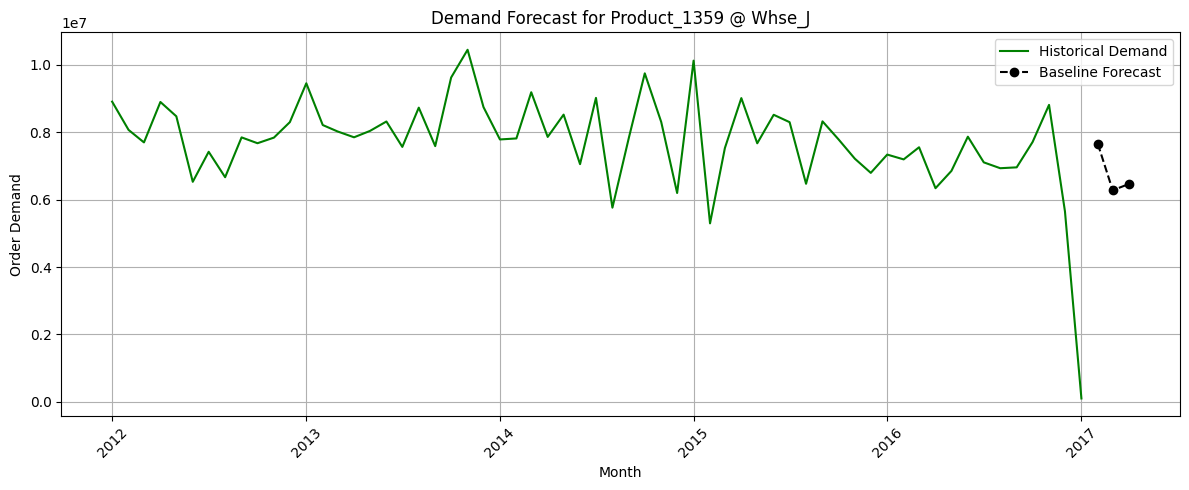

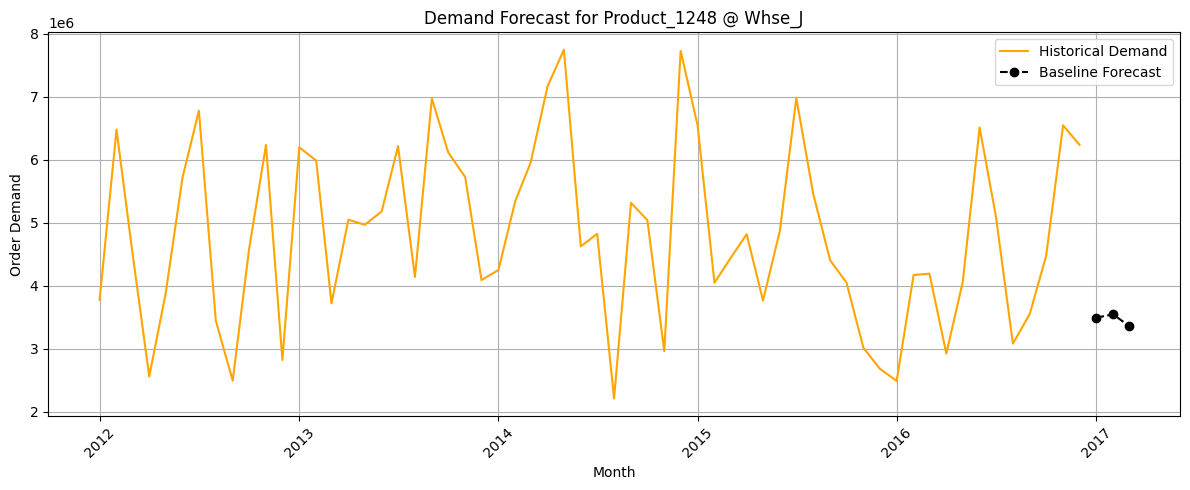

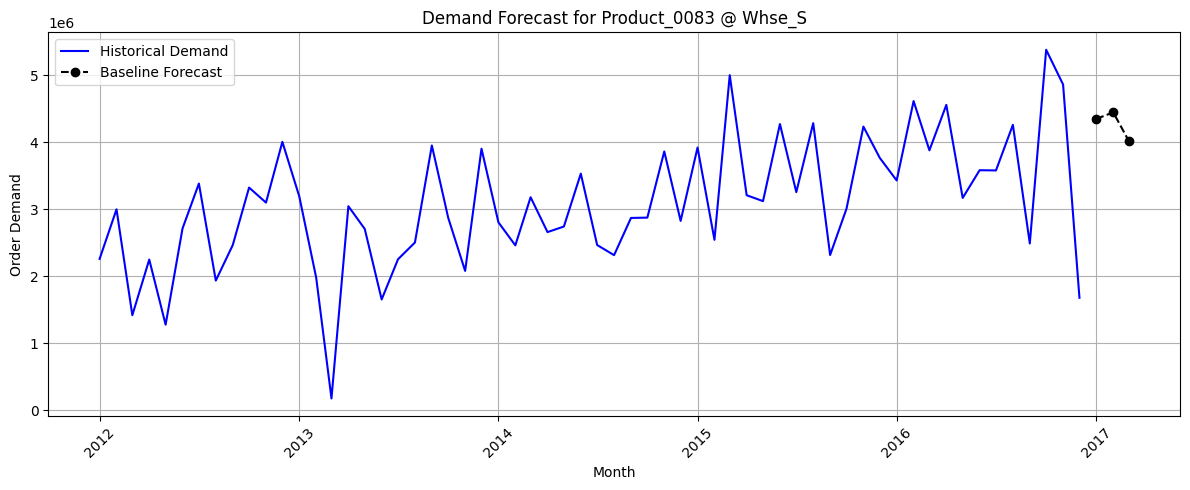

In [35]:

# Definition：original demand + baseline forecast
def plot_forecast(df, forecast_df, sku, warehouse, color):
    hist_data = df[(df['Product_Code'] == sku) & (df['Warehouse'] == warehouse)].copy()
    hist_data['Date'] = pd.to_datetime(hist_data['YearMonth'])
    hist_data = hist_data.sort_values('Date')

    forecast_df = forecast_df[forecast_df['SKU'] == f'{sku} @ {warehouse}']
    full_df = pd.concat([
        hist_data[['Date', 'Order_Demand']],
        forecast_df.rename(columns={'Month': 'Date', 'Forecast_Demand': 'Order_Demand'})[['Date', 'Order_Demand']]
    ])

    plt.figure(figsize=(12, 5))
    plt.plot(hist_data['Date'], hist_data['Order_Demand'], label='Historical Demand', color=color)
    plt.plot(forecast_df['Month'], forecast_df['Forecast_Demand'], linestyle='--', marker='o', label='Baseline Forecast', color='black')
    plt.title(f'Demand Forecast for {sku} @ {warehouse}')
    plt.xlabel('Month')
    plt.ylabel('Order Demand')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot
plot_forecast(grouped_df, forecast_all, 'Product_1359', 'Whse_J', 'green')
plot_forecast(grouped_df, forecast_all, 'Product_1248', 'Whse_J', 'orange')
plot_forecast(grouped_df, forecast_all, 'Product_0083', 'Whse_S', 'blue')
